In [28]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
#Import USA CO2 emissions data
df1 = pd.read_excel('USA.xlsx',
                   sheet_name='Sheet1',
                   usecols=[1, 2],
                   names=['YEAR', 'CO2 PRODUCTIONS IN TONS'],
                   header=1)

In [ ]:
# Import India CO2 emissions data
df2 = pd.read_excel('USA.xlsx',
                   sheet_name='Sheet2',
                   usecols=[1, 2],
                   names=['YEAR', 'CO2 PRODUCTIONS IN TONS'],
                   header=1)

In [2]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

In [5]:
emissions = df1['CO2 PRODUCTIONS IN TONS'].values.astype(float).reshape(-1,1)

usa_scaler = MinMaxScaler()
em_norm = usa_scaler.fit_transform(emissions)

seq_length = 5
X, y = create_sequences(em_norm, seq_length)

In [6]:
X_train_usa = torch.from_numpy(X).float()
y_train_usa = torch.from_numpy(y).float()

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [4]:
def train_ensemble(models, X_train, y_train, epochs=1500, lr=0.001, decay=0.0000001, early_stopping=0.0005):
    criterion = nn.MSELoss()
    X_train = X_train
    y_train = y_train
    for i, model in enumerate(models):
        model
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=decay)
        print(f'Training model {i+1}...')
        for epoch in range(epochs):
            model.train()
            pred = model(X_train)
            loss = criterion(pred, y_train)
            if loss.item() < early_stopping:
                print(f'  Model {i+1} | Epoch {epoch:4d}/{epochs} | Loss: {loss.item():.6f} (Early Stopping)')
                break
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0 or epoch == 1 or epoch == epochs:
                print(f'  Model {i+1} | Epoch {epoch:4d}/{epochs} | Loss: {loss.item():.6f}')
        
        print(f'--- Finished model {i+1} with final loss {loss.item():.6f} ---\n')

In [ ]:
torch.manual_seed(2)
n_models = 5                   # Number of models in the ensemble
usa_models = []
for i in range(n_models):
    model = LSTMModel()
    usa_models.append(model)

criterion = nn.MSELoss()

In [61]:
train_ensemble(usa_models, X_train_usa, y_train_usa, epochs=sys.maxsize, early_stopping=0.0005)

Training model 1...
  Model 1 | Epoch    0/9223372036854775807 | Loss: 0.640181
  Model 1 | Epoch    1/9223372036854775807 | Loss: 0.629394
  Model 1 | Epoch  100/9223372036854775807 | Loss: 0.046202
  Model 1 | Epoch  200/9223372036854775807 | Loss: 0.030574
  Model 1 | Epoch  300/9223372036854775807 | Loss: 0.025354
  Model 1 | Epoch  400/9223372036854775807 | Loss: 0.023756
  Model 1 | Epoch  500/9223372036854775807 | Loss: 0.021943
  Model 1 | Epoch  600/9223372036854775807 | Loss: 0.019770
  Model 1 | Epoch  700/9223372036854775807 | Loss: 0.017115
  Model 1 | Epoch  800/9223372036854775807 | Loss: 0.014322
  Model 1 | Epoch  900/9223372036854775807 | Loss: 0.012976
  Model 1 | Epoch 1000/9223372036854775807 | Loss: 0.012682
  Model 1 | Epoch 1100/9223372036854775807 | Loss: 0.012510
  Model 1 | Epoch 1200/9223372036854775807 | Loss: 0.012353
  Model 1 | Epoch 1300/9223372036854775807 | Loss: 0.012196
  Model 1 | Epoch 1400/9223372036854775807 | Loss: 0.012033
  Model 1 | Epoch 15

In [62]:
X = df2['YEAR'].values.reshape(-1,1)
y = df2['CO2 PRODUCTIONS IN TONS'].values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [ ]:
# Initializing the degree 2 polynomial regression model
degree = 2
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

In [65]:
poly_model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [66]:
test_score = poly_model.score(X_test, y_test)
print(f'Polynomial regressor R² on test: {test_score:.4f}')

Polynomial regressor R² on test: 0.1455


In [ ]:
prediction_years = 30

for model in usa_models:
    model.eval()
last_seq = em_norm[-seq_length:].tolist()

usa_future_emissions_all = []
for model in usa_models:
    future_preds = []
    for _ in range(prediction_years):
        seq_window = np.array(last_seq[-seq_length:])
        seq_input  = torch.from_numpy(seq_window).float()
        seq_input  = seq_input.unsqueeze(0)

        with torch.no_grad():
            next_norm = model(seq_input).item()
        future_preds.append(next_norm)
        last_seq.append([next_norm])

    future_emissions = usa_scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
    usa_future_emissions_all.append(future_emissions)
usa_future_emissions_all = np.array(usa_future_emissions_all)
usa_future_emissions_mean = np.mean(usa_future_emissions_all, axis=0)

last_year = int(df2['YEAR'].iloc[-1])
future_years = np.arange(last_year+1, last_year+1+prediction_years).reshape(-1,1)

india_future_emissions = poly_model.predict(future_years)

In [83]:
final_usa_data = np.concatenate((emissions.flatten(), usa_future_emissions_mean), axis=0)
final_india_data = np.concatenate((y, india_future_emissions), axis=0)
total_years = np.concatenate((X.flatten(), future_years.flatten()), axis=0)

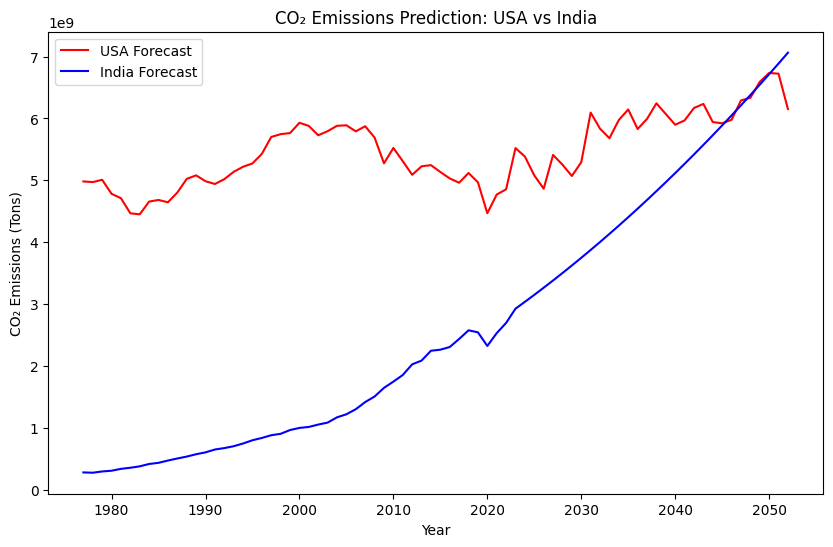

In [86]:
plt.figure(figsize=(10,6))
plt.plot(total_years, final_usa_data, '-', label='USA Forecast', color='red')
plt.plot(total_years, final_india_data, '-', label='India Forecast', color='blue')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (Tons)')
plt.title('CO₂ Emissions Prediction: USA vs India')
plt.legend()
plt.savefig('co2_emissions_forecast.png', dpi=300)
plt.show()

Extension of the project with share of CO_2 emissions of the two countries.

In [13]:
#Import USA CO2 emissions data
df_1 = pd.read_excel('Book3.xlsx',
                   sheet_name='Sheet1',
                   usecols=[0, 2],
                   names=['YEAR', 'USA'],
                   header=1)

In [15]:
# Import India CO2 emissions data
df_2 = pd.read_excel('Book3.xlsx',
                   sheet_name='Sheet1',
                   usecols=[0, 1],
                   names=['YEAR', 'INDIA'],
                   header=1)

In [18]:
emissions = df_1['USA'].values.astype(float).reshape(-1,1)

usa_scaler = MinMaxScaler()
em_norm = usa_scaler.fit_transform(emissions)

seq_length = 5
X, y = create_sequences(em_norm, seq_length)

In [19]:
X_train_usa = torch.from_numpy(X).float()
y_train_usa = torch.from_numpy(y).float()

In [51]:
torch.manual_seed(2)
n_models = 1                   # Number of models in the ensemble
usa_models = []
for i in range(n_models):
    model = LSTMModel()
    usa_models.append(model)

criterion = nn.MSELoss()

In [52]:
train_ensemble(usa_models, X_train_usa, y_train_usa, epochs=sys.maxsize, early_stopping=0.0005)

Training model 1...
  Model 1 | Epoch    0/9223372036854775807 | Loss: 0.632915
  Model 1 | Epoch    1/9223372036854775807 | Loss: 0.622082
  Model 1 | Epoch  100/9223372036854775807 | Loss: 0.040549
  Model 1 | Epoch  200/9223372036854775807 | Loss: 0.012349
  Model 1 | Epoch  300/9223372036854775807 | Loss: 0.003635
  Model 1 | Epoch  400/9223372036854775807 | Loss: 0.003473
  Model 1 | Epoch  500/9223372036854775807 | Loss: 0.003397
  Model 1 | Epoch  600/9223372036854775807 | Loss: 0.003315
  Model 1 | Epoch  700/9223372036854775807 | Loss: 0.003228
  Model 1 | Epoch  800/9223372036854775807 | Loss: 0.003135
  Model 1 | Epoch  900/9223372036854775807 | Loss: 0.003036
  Model 1 | Epoch 1000/9223372036854775807 | Loss: 0.002928
  Model 1 | Epoch 1100/9223372036854775807 | Loss: 0.002811
  Model 1 | Epoch 1200/9223372036854775807 | Loss: 0.002684
  Model 1 | Epoch 1300/9223372036854775807 | Loss: 0.002545
  Model 1 | Epoch 1400/9223372036854775807 | Loss: 0.002393
  Model 1 | Epoch 15

In [53]:
X = df_2['YEAR'].values.reshape(-1,1)
y = df_2['INDIA'].values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [54]:
linear_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

In [55]:
linear_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [56]:
prediction_years = 50

for model in usa_models:
    model.eval()
last_seq = em_norm[-seq_length:].tolist()

usa_future_emissions_all = []
for model in usa_models:
    future_preds = []
    for _ in range(prediction_years):
        seq_window = np.array(last_seq[-seq_length:])
        seq_input  = torch.from_numpy(seq_window).float()
        seq_input  = seq_input.unsqueeze(0)

        with torch.no_grad():
            next_norm = model(seq_input).item()
        future_preds.append(next_norm)
        last_seq.append([next_norm])

    future_emissions = usa_scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
    usa_future_emissions_all.append(future_emissions)
usa_future_emissions_all = np.array(usa_future_emissions_all)
usa_future_emissions_mean = np.mean(usa_future_emissions_all, axis=0)

last_year = int(df_2['YEAR'].iloc[-1])
future_years = np.arange(last_year+1, last_year+1+prediction_years).reshape(-1,1)

india_future_emissions = linear_model.predict(future_years)

In [57]:
final_usa_data = np.concatenate((emissions.flatten(), usa_future_emissions_mean), axis=0)
final_india_data = np.concatenate((y, india_future_emissions), axis=0)
total_years = np.concatenate((X.flatten(), future_years.flatten()), axis=0)

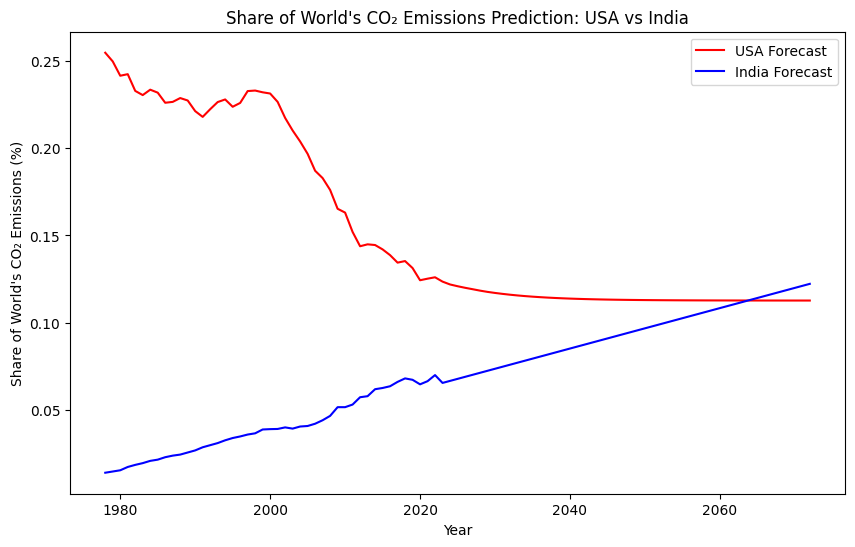

In [58]:
plt.figure(figsize=(10,6))
plt.plot(total_years, final_usa_data, '-', label='USA Forecast', color='red')
plt.plot(total_years, final_india_data, '-', label='India Forecast', color='blue')
plt.xlabel('Year')
plt.ylabel('Share of World\'s CO₂ Emissions (%)')
plt.title('Share of World\'s CO₂ Emissions Prediction: USA vs India')
plt.legend()
plt.savefig('co2_emissions_share_forecast.png', dpi=300)
plt.show()

In [60]:
def search_intersection(final_usa_data, final_india_data):
    intersection_year = None
    for i in range(len(final_usa_data)):
        if final_india_data[i] >= final_usa_data[i]:
            intersection_year = total_years[i]
            break
    return intersection_year

intersection_year = search_intersection(final_usa_data, final_india_data)
print(f'Intersection Year: {intersection_year}')

Intersection Year: 2064
